# 文献準拠ベンチマーク（Doc Benchmark）

このノートブックは、論文準拠のモメンタムベンチマークを**単独で**再現するためのフルコードをまとめたものです。

前提
- ユニバース: 指定ETF（SPY, IWM, EFA, EEM, AGG, TLT, LQD, HYG, EMB, GLD, DBC, VNQ）
- リバランス: 月次
- ポジション: ロングのみ
- 取引コスト: 5 bps（回転率ベース）
- 未来情報は使わず、月末時点までの情報で翌月を運用

出力
- 図: `output/plots/`
- 表: `output/tables/`

## 1. 依存関係と設定

In [1]:
import os
from pathlib import Path

# Matplotlib cache to writable dir
mpl_cache = Path("output/.mpl_cache")
mpl_cache.mkdir(parents=True, exist_ok=True)
os.environ.setdefault("MPLCONFIGDIR", str(mpl_cache))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False

DATA_PATH = Path("data/etf_prices.csv")
OUT_PLOTS = Path("output/plots")
OUT_TABLES = Path("output/tables")
OUT_PLOTS.mkdir(parents=True, exist_ok=True)
OUT_TABLES.mkdir(parents=True, exist_ok=True)

TICKERS = [
    "SPY", "IWM", "EFA", "EEM",
    "AGG", "TLT", "LQD", "HYG", "EMB",
    "GLD", "DBC",
    "VNQ",
]

## 2. データ読み込み
`etf_prices.csv` は二段ヘッダ（Price / Adj Close 形式）にも対応します。

In [2]:
def load_prices(csv_path: Path, tickers: list[str]) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], utc=False)
        df = df.set_index("Date").sort_index()
        missing = [t for t in tickers if t not in df.columns]
        if missing:
            raise ValueError(f"Missing tickers in CSV: {missing}")
        df = df[tickers].astype(float)
        df = df.ffill().dropna(how="all")
        return df

    # 2-row header (field, ticker)
    df2 = pd.read_csv(csv_path, header=[0, 1])
    if ("Price", "Ticker") in df2.columns:
        date_col = df2[("Price", "Ticker")]
    else:
        date_col = df2.iloc[:, 0]

    date_col = pd.to_datetime(date_col, errors="coerce", utc=False, format="%Y-%m-%d")
    if date_col.isna().all():
        date_col = pd.to_datetime(date_col, errors="coerce", utc=False)

    df2[("Date", "")] = date_col
    df2 = df2.loc[~df2[("Date", "")].isna()]
    df2 = df2.set_index(("Date", "")).sort_index()
    df2.index.name = "Date"

    field = "Adj Close" if "Adj Close" in df2.columns.get_level_values(0) else "Close"
    if field not in df2.columns.get_level_values(0):
        raise ValueError("Could not find Adj Close or Close field in CSV")

    adj = df2[field]
    missing = [t for t in tickers if t not in adj.columns]
    if missing:
        raise ValueError(f"Missing tickers in CSV: {missing}")

    adj = adj[tickers].astype(float)
    adj = adj.ffill().dropna(how="all")
    return adj


def month_end_prices(prices: pd.DataFrame) -> pd.DataFrame:
    try:
        return prices.resample("M").last().dropna(how="all")
    except ValueError:
        return prices.resample("ME").last().dropna(how="all")


def monthly_returns(prices: pd.DataFrame) -> pd.DataFrame:
    me = month_end_prices(prices)
    return me.pct_change().dropna(how="all")


prices = load_prices(DATA_PATH, TICKERS)
prices.tail()

,SPY,IWM,EFA,EEM,AGG,TLT,LQD,HYG,EMB,GLD,DBC,VNQ
Date,,,,,,,,,,,,
2026-02-03,689.530029,262.779999,101.449997,59.599998,99.699997,86.760002,110.110001,80.720001,96.160004,454.290009,24.150000,89.660004
2026-02-04,686.190002,260.519989,101.779999,58.799999,99.639999,86.540001,109.970001,80.620003,96.199997,453.970001,24.190001,90.949997
2026-02-05,677.619995,255.830002,100.330002,58.529999,100.070000,87.480003,110.500000,80.529999,96.440002,441.880005,23.760000,90.820000
2026-02-06,690.619995,265.019989,102.610001,60.070000,100.129997,87.540001,110.559998,80.809998,96.690002,455.459991,24.010000,92.250000
2026-02-09,693.950012,266.880005,103.989998,60.509998,100.160004,87.519997,110.559998,80.919998,96.720001,467.029999,24.250000,92.639999


## 3. シグナル定義（論文準拠）

定義（概念式）
- 1Mモメンタム: \(\log(P_t / P_{t-21})\)
- 12-1Mモメンタム: \(\log(P_{t-21} / P_{t-252})\)
- MAクロス: \(	ext{MA}_{10} / 	ext{MA}_{200} - 1\)

クロスセクション z-score を取り、3シグナルの平均をスコアとする。

In [3]:
def _safe_zscore(df: pd.DataFrame) -> pd.DataFrame:
    mean = df.mean(axis=1)
    std = df.std(axis=1).replace(0.0, np.nan)
    return (df.sub(mean, axis=0)).div(std, axis=0)


def momentum_1m(prices: pd.DataFrame, lookback: int = 21) -> pd.DataFrame:
    return np.log(prices / prices.shift(lookback))


def momentum_12_1(prices: pd.DataFrame, lookback: int = 252, skip: int = 21) -> pd.DataFrame:
    return np.log(prices.shift(skip) / prices.shift(lookback))


def ma_ratio(prices: pd.DataFrame, fast: int = 10, slow: int = 200) -> pd.DataFrame:
    ma_fast = prices.rolling(fast).mean()
    ma_slow = prices.rolling(slow).mean()
    return ma_fast.div(ma_slow) - 1.0


def rolling_vol(returns: pd.DataFrame, lookback: int = 63) -> pd.DataFrame:
    return returns.rolling(lookback).std()


def return_to_vol(momentum: pd.DataFrame, vol: pd.DataFrame) -> pd.DataFrame:
    return momentum.div(vol.replace(0.0, np.nan))


def multi_signal_score(prices: pd.DataFrame) -> pd.DataFrame:
    mom1 = momentum_1m(prices)
    mom12 = momentum_12_1(prices)
    ma = ma_ratio(prices)
    score = (_safe_zscore(mom1) + _safe_zscore(mom12) + _safe_zscore(ma)) / 3.0
    return score

score = multi_signal_score(prices)
score.tail()

,SPY,IWM,EFA,EEM,AGG,TLT,LQD,HYG,EMB,GLD,DBC,VNQ
Date,,,,,,,,,,,,
2026-02-03,-0.230324,0.282667,0.438368,0.936786,-0.710525,-0.833266,-0.672651,-0.630340,-0.477975,2.436405,0.213919,-0.753064
2026-02-04,-0.287989,0.210357,0.505498,0.834360,-0.709370,-0.892193,-0.685478,-0.629624,-0.470883,2.448249,0.246205,-0.569131
2026-02-05,-0.535167,-0.089730,0.465866,0.836663,-0.608162,-0.705537,-0.581006,-0.608077,-0.377677,2.430323,0.297316,-0.524811
2026-02-06,-0.321464,0.170478,0.524686,0.981849,-0.728019,-0.902514,-0.705659,-0.667993,-0.462337,2.394379,0.204973,-0.488378
2026-02-09,-0.298794,0.125778,0.586264,0.973821,-0.722230,-0.882585,-0.695480,-0.669074,-0.465608,2.467866,0.137331,-0.557288


## 4. 文献準拠ベンチマーク（Doc Benchmark）構築

スコアをボラで調整し、ロングのみで正規化する。

- \(s_t = 
rac{1}{3}(z(mom1_t) + z(mom12_{t}) + z(ma_t))\)
- \(	ilde{s}_t = s_t / \sigma_{63,t}\)
- \(w_t \propto \max(	ilde{s}_t, 0)\)

In [4]:
def eqw_weights(tickers: list[str]) -> pd.Series:
    return pd.Series(1.0 / len(tickers), index=tickers)


def doc_benchmark_weights(prices: pd.DataFrame, vol_lookback: int = 63) -> pd.Series:
    score = multi_signal_score(prices)
    vol = rolling_vol(prices.pct_change(), lookback=vol_lookback)
    score_adj = return_to_vol(score, vol)

    latest = score_adj.iloc[-1]
    latest = latest.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    latest = latest.clip(lower=0.0)

    if latest.sum() == 0.0:
        return eqw_weights(list(prices.columns))

    return latest / latest.sum()

# サンプル: 最新日付のウェイト
weights_latest = doc_benchmark_weights(prices)
weights_latest

SPY    0.000000
IWM    0.033385
EFA    0.231203
EEM    0.332650
AGG    0.000000
TLT    0.000000
LQD    0.000000
HYG    0.000000
EMB    0.000000
GLD    0.364297
DBC    0.038465
VNQ    0.000000
Name: 2026-02-09 00:00:00, dtype: float64

## 5. バックテスト（月次リバランス・未来情報なし）

手順
1. 月末までの価格でスコアを計算
2. 月末時点のウェイトで **翌月リターン** を運用
3. 回転率ベースで取引コスト（5 bps）を控除

In [5]:
COST_BPS = 5


def max_drawdown(series: pd.Series) -> float:
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1.0
    return float(dd.min())


def performance_summary(returns: pd.Series) -> dict:
    ann_return = float((1 + returns).prod() ** (12.0 / len(returns)) - 1.0)
    ann_vol = float(np.sqrt(12.0) * returns.std())
    sharpe = float(np.sqrt(12.0) * returns.mean() / returns.std()) if returns.std() != 0 else 0.0
    return {
        "annual_return": ann_return,
        "annual_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown(returns),
    }


def backtest_doc_benchmark(prices: pd.DataFrame, cost_bps: float = COST_BPS):
    m_returns = monthly_returns(prices)
    next_returns = m_returns.shift(-1)

    weights = {}
    for dt in m_returns.index[:-1]:
        w = doc_benchmark_weights(prices.loc[:dt])
        weights[dt] = w

    weights_df = pd.DataFrame(weights).T
    aligned = next_returns.reindex(weights_df.index)
    pnl = (weights_df * aligned).sum(axis=1)

    turnover = weights_df.diff().abs().sum(axis=1).fillna(0.0)
    cost = turnover * (cost_bps / 10000.0)
    returns = (pnl - cost).dropna()
    return returns, weights_df


returns, weights = backtest_doc_benchmark(prices)
summary = performance_summary(returns)
summary

{'annual_return': 0.10288261233920482,
 'annual_vol': 0.10925930064038133,
 'sharpe': 0.9539279329410135,
 'max_drawdown': -0.1719216129948642}

## 6. 可視化

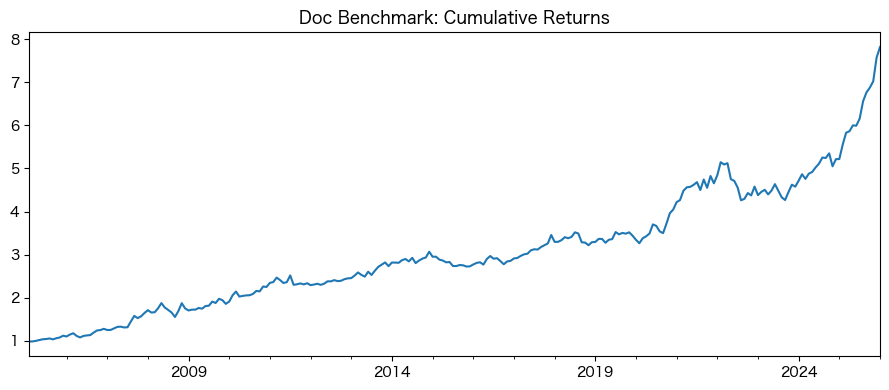

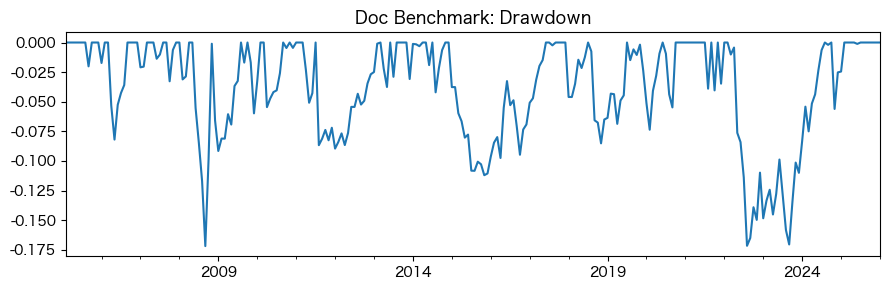

In [6]:
# 累積リターン
cum = (1 + returns).cumprod()
ax = cum.plot(figsize=(9, 4), title="Doc Benchmark: Cumulative Returns")
plt.tight_layout()
plt.savefig(OUT_PLOTS / "doc_benchmark_cumret.png", dpi=150)
plt.show()

# ドローダウン
peak = cum.cummax()
dd = cum / peak - 1
ax = dd.plot(figsize=(9, 3), title="Doc Benchmark: Drawdown")
plt.tight_layout()
plt.savefig(OUT_PLOTS / "doc_benchmark_drawdown.png", dpi=150)
plt.show()

## 7. 年次サマリー

In [7]:
def annual_summary(returns: pd.Series) -> pd.DataFrame:
    out = []
    for year, r in returns.groupby(returns.index.year):
        if len(r) == 0:
            continue
        ann_return = (1 + r).prod() - 1
        ann_vol = np.sqrt(12.0) * r.std()
        sharpe = np.sqrt(12.0) * r.mean() / r.std() if r.std() != 0 else 0.0
        # Max drawdown within year
        cum = (1 + r).cumprod()
        dd = cum / cum.cummax() - 1
        out.append([year, ann_return, ann_vol, sharpe, float(dd.min())])
    df = pd.DataFrame(out, columns=["year", "annual_return", "annual_vol", "sharpe", "max_drawdown"])
    return df.set_index("year")

annual = annual_summary(returns)
annual.to_csv(OUT_TABLES / "doc_benchmark_annual_summary.csv")
annual

,annual_return,annual_vol,sharpe,max_drawdown
year,,,,
2005,0.118837,0.060098,2.075932,-0.020128
2006,0.141861,0.109292,1.270833,-0.081965
2007,0.287216,0.144175,1.833337,-0.032740
2008,0.065311,0.216103,0.390794,-0.171922
2009,0.060221,0.106336,0.599592,-0.059815
2010,0.211051,0.115838,1.718931,-0.054567
2011,0.038464,0.137016,0.339654,-0.086706
2012,0.048632,0.041952,1.153401,-0.010663
2013,0.115603,0.095718,1.191816,-0.037551


## 8. 参考: ウェイトの推移（直近12ヶ月）

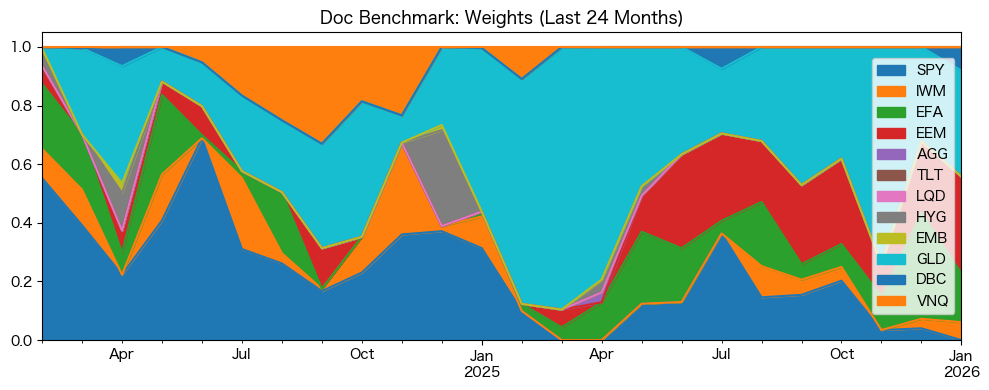

In [8]:
N = 24
weights_tail = weights.tail(N)

# 表示
weights_tail

# スタックエリアで推移を可視化
ax = weights_tail.plot(kind="area", stacked=True, figsize=(10, 4), title=f"Doc Benchmark: Weights (Last {N} Months)")
plt.tight_layout()
plt.savefig(OUT_PLOTS / "doc_benchmark_weights.png", dpi=150)
plt.show()
